In [1]:
from dolphindb import session
import numpy as np
import pandas as pd
import json
from datetime import datetime, timedelta
import sys
import os
import traceback
from scipy.interpolate import CubicSpline
import yfinance as yf
# Import libraries for data visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import pandas as pd
from datetime import datetime, timedelta

# Set the style for plotting
plt.style.use('fivethirtyeight')
sns.set_palette('colorblind')

In [2]:
def get_data(ticker=None, period='2y', interval='1h'):
    """
    Get stock data from Yahoo Finance
    
    Parameters:
    ticker (str): Ticker symbol (e.g., 'PETR4.SA')
    period (str): Period to download ('1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', '5y', '10y', 'ytd', 'max')
    interval (str): Data interval ('1m', '2m', '5m', '15m', '30m', '60m', '90m', '1h', '1d', '5d', '1wk', '1mo', '3mo')
    
    Returns:
    DataFrame: DataFrame with OHLCV data
    """
    if ticker is None:
        return None
    
    try:
        data = yf.download(ticker, period=period, interval=interval)
        
        # If we need data in a different format for the original functions
        # Convert the data to the format expected by calculate_returns
        transformed_data = data.copy()
        transformed_data.reset_index(inplace=True)
        transformed_data.rename(columns={'index': 'Datetime'}, inplace=True)
        transformed_data['Symbol'] = ticker
        
        return transformed_data
    
    except Exception as e:
        print(f"Error downloading data: {str(e)}")
        return None

In [3]:
def calculate_returns(data, ticker, period, iterations, forecast_days, hours_per_day=7):
    """
    Calculate returns and run Monte Carlo bootstrap simulation on hourly data
    
    Parameters:
    data (DataFrame): DataFrame with OHLCV data from yfinance
    ticker (str): Ticker symbol
    period (int): Period in months for historical data analysis
    iterations (int): Number of Monte Carlo iterations
    forecast_days (int): Number of days to forecast
    hours_per_day (int): Average number of trading hours per day, default is 7
    
    Returns:
    dict: Results of the Monte Carlo simulation
    """
    # No need to filter by date since yfinance already handles this
    # Copy the dataframe to avoid modifying the original
    asset_df = data.copy()
    
    # Check if we have the right columns and structure
    print(f"DataFrame columns: {asset_df.columns.tolist()}")
    print(f"DataFrame shape: {asset_df.shape}")
    
    # Calculate returns - ensure 'Close' exists in the data
    if 'Close' not in asset_df.columns and 'close' in asset_df.columns:
        asset_df['Close'] = asset_df['close']
    
    # Calculate returns
    asset_df['simple_return'] = asset_df['Close'].pct_change()
    asset_df['log_return'] = np.log(1 + asset_df['simple_return'])
    
    # Drop NaN values safely
    asset_df = asset_df.dropna(subset=['simple_return', 'log_return'])
    
    # Get empirical distribution of returns
    cdf_values = calculate_cdf_values(asset_df)
    
    # Run Monte Carlo simulation
    # Calculate time_steps as hours_per_day * forecast_days
    time_steps = hours_per_day * forecast_days
    mc_results = mc_bootstrap(
        cdf_values['S0'], 
        cdf_values['interpolated_cdf_values'], 
        cdf_values['sorted_values'], 
        time_steps=time_steps, 
        iterations=iterations,
        hours_per_day=hours_per_day
    )
    
    # Prepare results
    results = {
        'ticker': ticker,
        'last_price': float(cdf_values['S0']),
        'historical_stats': {
            'mean_return': float(asset_df['simple_return'].mean()),
            'std_return': float(asset_df['simple_return'].std()),
            'median_return': float(asset_df['simple_return'].median()),
            'skew': float(asset_df['simple_return'].skew()),
            'kurtosis': float(asset_df['simple_return'].kurtosis())
        },
        'monte_carlo': mc_results
    }
    
    return results, asset_df

def calculate_cdf_values(asset_df):
    sorted_values = np.unique(np.sort(asset_df['log_return']))
    ecdf = np.arange(1, len(sorted_values) + 1) / len(sorted_values)
    cs = CubicSpline(sorted_values, ecdf)
    interpolated_cdf_values = cs(sorted_values)

    min_length = min(len(sorted_values), len(interpolated_cdf_values))
    sorted_values = sorted_values[:min_length]
    interpolated_cdf_values = interpolated_cdf_values[:min_length]
    sf_interpolated = 1 - interpolated_cdf_values
    S0 = asset_df['Close'].iloc[-1]
    mu = np.median(asset_df['log_return'])

    return {
        'S0': float(S0),
        'sf_interpolated': sf_interpolated.tolist(),
        'sorted_values': sorted_values.tolist(),
        'interpolated_cdf_values': interpolated_cdf_values.tolist(),
        'mu': float(mu)
    }

def mc_bootstrap(S0, cdf_empirical_interpolated, sorted_values, time_steps, iterations, hours_per_day=7):
    """
    Run Monte Carlo bootstrap simulation with hourly data aggregated to daily paths.
    
    Parameters:
    S0 (float): Starting price
    cdf_empirical_interpolated (list): Interpolated CDF values
    sorted_values (list): Sorted log returns
    time_steps (int): Number of hourly steps to simulate
    iterations (int): Number of Monte Carlo iterations
    hours_per_day (int): Average number of trading hours per day
    
    Returns:
    dict: Simulation results including both hourly and daily paths
    """
    def _run_simulation(time_steps, iterations):
        U = np.random.rand(time_steps, iterations)
        Z = np.interp(U, cdf_empirical_interpolated, sorted_values)
        factor = np.exp(Z)
        
        # Hourly paths calculation
        hourly_paths = S0 * np.cumprod(factor, axis=0)
        
        # Reshape to get daily paths (assuming hours_per_day trading hours per day)
        days = time_steps // hours_per_day
        remainder = time_steps % hours_per_day
        
        # Add padding if needed to make the array divisible by hours_per_day
        if remainder > 0:
            padding = hours_per_day - remainder
            # Repeat the last row for padding
            pad = np.tile(hourly_paths[-1, :], (padding, 1))
            hourly_paths = np.vstack([hourly_paths, pad])
            time_steps += padding
        
        # Reshape to (days, hours_per_day, iterations) and get daily closing prices
        reshaped_paths = hourly_paths.reshape(time_steps // hours_per_day, hours_per_day, iterations)
        daily_paths = reshaped_paths[:, -1, :] # Take the last hour of each day
        
        # Final values
        arrival_values = hourly_paths[-1]
        
        return hourly_paths, daily_paths, arrival_values
    
    hourly_paths, daily_paths, arrival_values = _run_simulation(time_steps, iterations)
    
    # Calculate statistics for the final values
    stats = {
        'mean': float(np.mean(arrival_values)),
        'median': float(np.median(arrival_values)),
        'std': float(np.std(arrival_values)),
        'min': float(np.min(arrival_values)),
        'max': float(np.max(arrival_values)),
        'percentiles': {
            '1%': float(np.percentile(arrival_values, 1)),
            '5%': float(np.percentile(arrival_values, 5)),
            '25%': float(np.percentile(arrival_values, 25)),
            '75%': float(np.percentile(arrival_values, 75)),
            '95%': float(np.percentile(arrival_values, 95)),
            '99%': float(np.percentile(arrival_values, 99))
        }
    }
    
    # Save a subset of paths for visualization
    sample_size = min(100, iterations)
    indices = np.random.choice(iterations, sample_size, replace=False)
    
    return {
        'stats': stats,
        'hourly_paths': hourly_paths[:, indices].tolist(),  # Sample paths for plotting
        'daily_paths': daily_paths[:, indices].tolist(),    # Daily paths for plotting
        'path_count': sample_size,
        'days': time_steps // hours_per_day,
        'hours_per_day': hours_per_day
    }

def run_bootstrap(ticker, period_str, iterations, forecast_days, hours_per_day=7):
    """
    Runs the bootstrap simulation for a given ticker
    
    Parameters:
    ticker (str): Ticker symbol
    period_str (str): Period for historical data in yfinance format (e.g., '1y', '2y')
    iterations (int): Number of Monte Carlo iterations
    forecast_days (int): Number of days to forecast
    hours_per_day (int): Average trading hours per day
    
    Returns:
    dict: Simulation results
    """
    try:
        # Download data directly via yfinance
        print(f"Downloading data for {ticker} with period={period_str}, interval=1h")
        data = yf.download(ticker, period=period_str, interval='1h')
        
        if data is None or len(data) == 0:
            raise Exception(f"Failed to query data for {ticker}")
            
        print(f"Downloaded {len(data)} records")
        
        # Ensure compatible column names
        # yfinance returns columns like 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'
        # ensure 'Close' exists (it should already in yfinance output)
        if 'Close' not in data.columns and 'close' in [col.lower() for col in data.columns]:
            for col in data.columns:
                if col.lower() == 'close':
                    data['Close'] = data[col]
                    break

        results, asset_df = calculate_returns(data, ticker, period_str, iterations, forecast_days, hours_per_day)
        return results, asset_df, data

    except Exception as e:
        print(f"Error in bootstrap execution: {str(e)}", file=sys.stderr)
        print(traceback.format_exc(), file=sys.stderr)
        raise

# Monte Carlo Bootstrap Simulation for Hourly Trading Data

This notebook implements a Monte Carlo bootstrap simulation using hourly trading data. The key advantages of this approach are:

1. **Captures intraday patterns** - Using hourly data provides more granularity than daily data
2. **More realistic price paths** - By using the empirical distribution of hourly returns
3. **Aggregation to daily forecasts** - While simulating at hourly resolution, we aggregate to daily closing prices

## Implementation Details

- The simulation uses hourly data from yfinance with a default interval of '1h'
- The average trading hours per day (~7 hours for Brazilian stocks) is used to aggregate hourly paths to daily paths
- The bootstrap approach samples from the empirical distribution of historical log returns
- Cubic spline interpolation is used to create a smooth CDF for sampling

## Key Functions

- `calculate_returns()` - Prepares the data and runs the simulation
- `calculate_cdf_values()` - Generates the empirical CDF for bootstrap sampling
- `mc_bootstrap()` - Runs the Monte Carlo simulation and aggregates hourly results to daily
- `run_bootstrap()` - Main entry point that downloads data and runs the simulation

In [4]:
# Define parameters
ticker = 'PETR4.SA'  # Brazilian stock - Petrobras
time_frame = '1h'
period = '2y'
iterations = 1000
forecast_days = 30  # Forecast for the next 30 days
hours_per_day = 7  # Based on the data analysis that shows ~7 trading hours per day

# Download stock data using yfinance
data = yf.download(ticker, period=period, interval=time_frame)
print(f"Downloaded {len(data)} records for {ticker}")
print(f"Date range: {data.index.min()} to {data.index.max()}")

# Display the first few rows of data
data.tail()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Downloaded 3490 records for PETR4.SA
Date range: 2023-05-15 14:00:00+00:00 to 2025-05-15 14:00:00+00:00


Price,Close,High,Low,Open,Volume
Ticker,PETR4.SA,PETR4.SA,PETR4.SA,PETR4.SA,PETR4.SA
Datetime,,,,,
2025-05-14 17:00:00+00:00,31.950001,32.049999,31.930000,32.000000,1940600
2025-05-14 18:00:00+00:00,31.940001,31.980000,31.850000,31.950001,3162500
2025-05-14 19:00:00+00:00,31.980000,32.009998,31.930000,31.940001,2833500
2025-05-15 13:00:00+00:00,31.770000,31.850000,31.590000,31.700001,6093400
2025-05-15 14:00:00+00:00,31.870001,31.889999,31.709999,31.760000,2854700


In [5]:
# Troubleshooting cell - run this if you encounter data format issues
def fix_data_format(data):
    """Ensure data has the correct format for the Monte Carlo bootstrap simulation"""
    # Create a copy to avoid modifying the original
    df = data.copy()
    
    # Check if dataframe is in the correct format
    if isinstance(df.index, pd.DatetimeIndex):
        print("DataFrame has DatetimeIndex - converting to standard format")
        # Convert from yfinance format to expected format
        df.reset_index(inplace=True)
        df.rename(columns={'index': 'Datetime'}, inplace=True)
    
    # Ensure required columns exist
    columns_lower = [col.lower() for col in df.columns]
    
    # Check for 'symbol' column
    if 'symbol' not in columns_lower:
        print("Adding Symbol column with ticker value")
        df['Symbol'] = ticker
    
    # Check for 'datetime' column
    if 'datetime' not in columns_lower:
        for col in df.columns:
            if col.lower() in ['date', 'time', 'timestamp']:
                print(f"Renaming '{col}' to 'Datetime'")
                df['Datetime'] = df[col]
                break
    
    # Check for 'close' column
    if 'close' not in columns_lower:
        if 'adj close' in columns_lower or 'adjusted close' in columns_lower:
            for col in df.columns:
                if col.lower() in ['adj close', 'adjusted close']:
                    print(f"Using '{col}' as 'Close' price")
                    df['Close'] = df[col]
                    break
    else:
        # Ensure proper capitalization
        for col in df.columns:
            if col.lower() == 'close' and col != 'Close':
                print(f"Renaming '{col}' to 'Close'")
                df['Close'] = df[col]
    
    # Show the resulting dataframe structure
    print("\nFixed DataFrame Structure:")
    print(f"Shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")
    
    # Return the fixed dataframe
    return df

# Uncomment and run the following line if you encounter data format issues
# data_fixed = fix_data_format(data)


===== Trading Hours Analysis =====
Average hours per day: 6.98
Median hours per day: 7.00
Minimum hours: 2.00
Maximum hours: 7.00
Mode: 7.00
Total trading days: 500.00
Days with data:
  7 hours: 496 days
  5 hours: 2 days
  6 hours: 1 days
  2 hours: 1 days

===== Trading Hours by Day of Week =====
               mean  median  min  max  count
DayName                                     
Friday     7.000000     7.0    7    7    100
Monday     6.990000     7.0    6    7    100
Thursday   6.949495     7.0    2    7     99
Tuesday    7.000000     7.0    7    7    101
Wednesday  6.960000     7.0    5    7    100


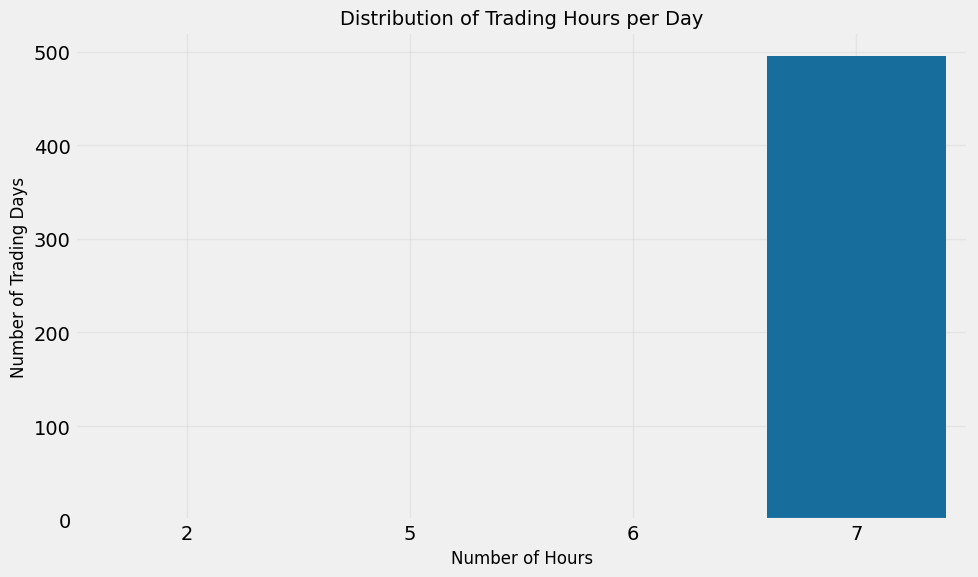

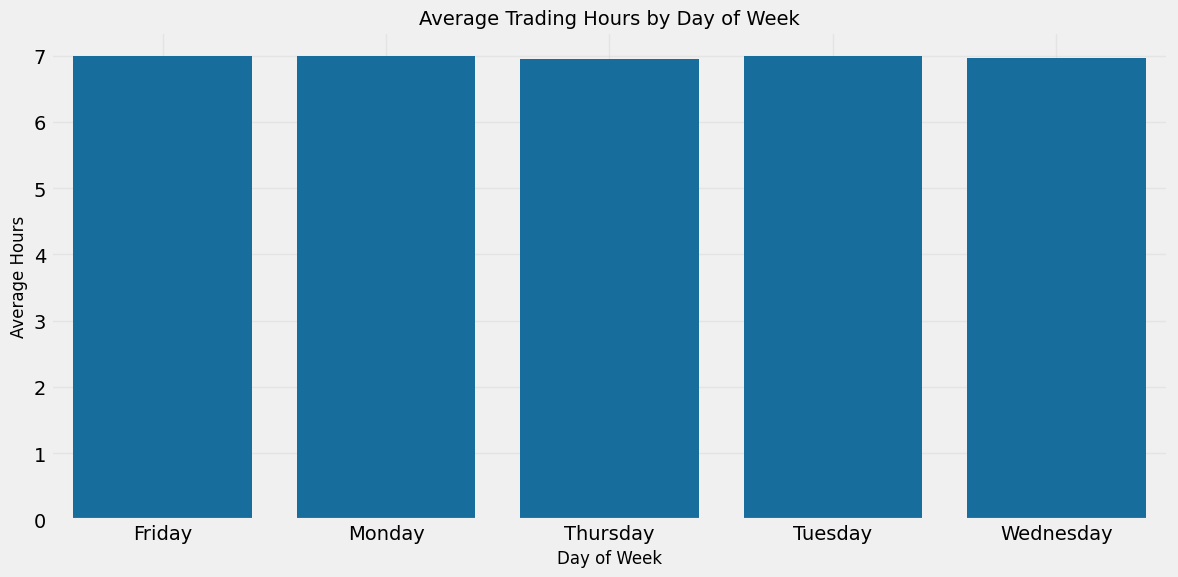


Based on this analysis, the recommended hours_per_day value is: 7


In [6]:
# Analyze trading hours per day to confirm our assumption of ~7 hours
def analyze_trading_hours(data):
    """
    Analyze the distribution of trading hours per day from hourly OHLCV data
    
    Parameters:
    data (DataFrame): DataFrame with OHLCV data from yfinance with datetime index
    
    Returns:
    tuple: (average_hours, dataframe_with_stats)
    """
    # Extract date and hour information
    date_summary = pd.DataFrame({
        'Date': data.index.date,
        'Hour': data.index.hour,
        'DayOfWeek': data.index.dayofweek,
        'DayName': data.index.day_name()
    })
    
    # Count hours per date
    hours_per_day = date_summary.groupby('Date').size()
    
    # Calculate statistics
    stats = {
        'Average hours per day': hours_per_day.mean(),
        'Median hours per day': hours_per_day.median(),
        'Minimum hours': hours_per_day.min(),
        'Maximum hours': hours_per_day.max(),
        'Mode': hours_per_day.mode().values[0],
        'Total trading days': len(hours_per_day),
        'Days with data': hours_per_day.value_counts().to_dict()
    }
    
    # Distribution by day of week
    day_of_week_hours = date_summary.groupby(['DayName', 'Date']).size().reset_index()
    day_of_week_stats = day_of_week_hours.groupby('DayName')[0].agg(['mean', 'median', 'min', 'max', 'count'])
    
    return stats, day_of_week_stats, hours_per_day

# Run the analysis
trading_stats, day_stats, hours_per_day = analyze_trading_hours(data)

# Print results
print("\n===== Trading Hours Analysis =====")
for key, value in trading_stats.items():
    if key != 'Days with data':
        print(f"{key}: {value:.2f}")
    else:
        print(f"{key}:")
        for hours, count in value.items():
            print(f"  {hours} hours: {count} days")

print("\n===== Trading Hours by Day of Week =====")
print(day_stats)

# Plot the distribution of trading hours
plt.figure(figsize=(10, 6))
sns.countplot(x=hours_per_day.values)
plt.title('Distribution of Trading Hours per Day', fontsize=14)
plt.xlabel('Number of Hours', fontsize=12)
plt.ylabel('Number of Trading Days', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot the average trading hours by day of week
plt.figure(figsize=(12, 6))
sns.barplot(x=day_stats.index, y=day_stats['mean'])
plt.title('Average Trading Hours by Day of Week', fontsize=14)
plt.xlabel('Day of Week', fontsize=12)
plt.ylabel('Average Hours', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Based on this analysis, calculate the recommended hours_per_day
recommended_hours = int(round(trading_stats['Mode']))
print(f"\nBased on this analysis, the recommended hours_per_day value is: {recommended_hours}")

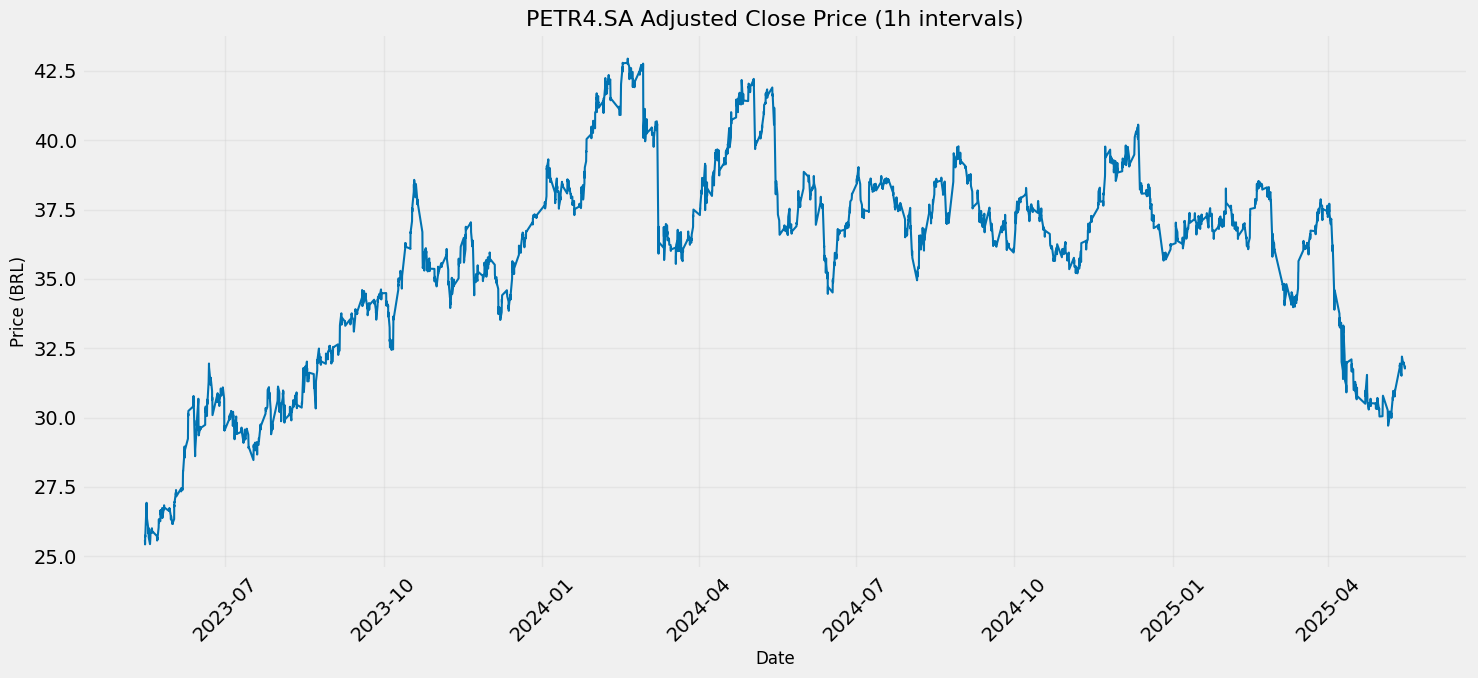


Trading hours per day statistics:
Average hours per trading day: 6.98
Minimum hours in a trading day: 2
Maximum hours in a trading day: 7
Median hours per trading day: 7.00


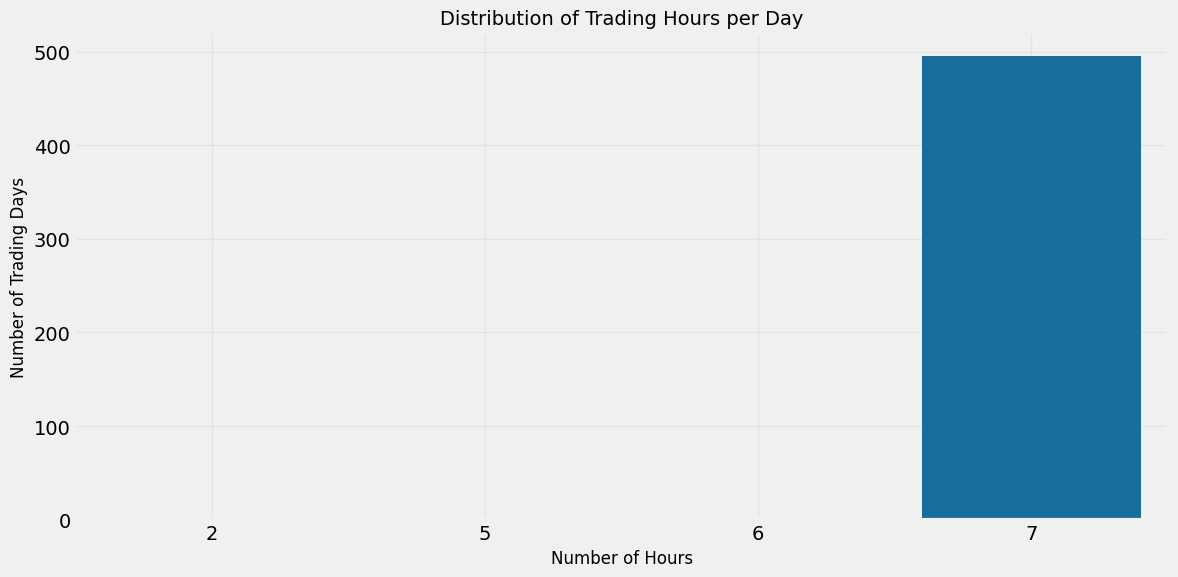

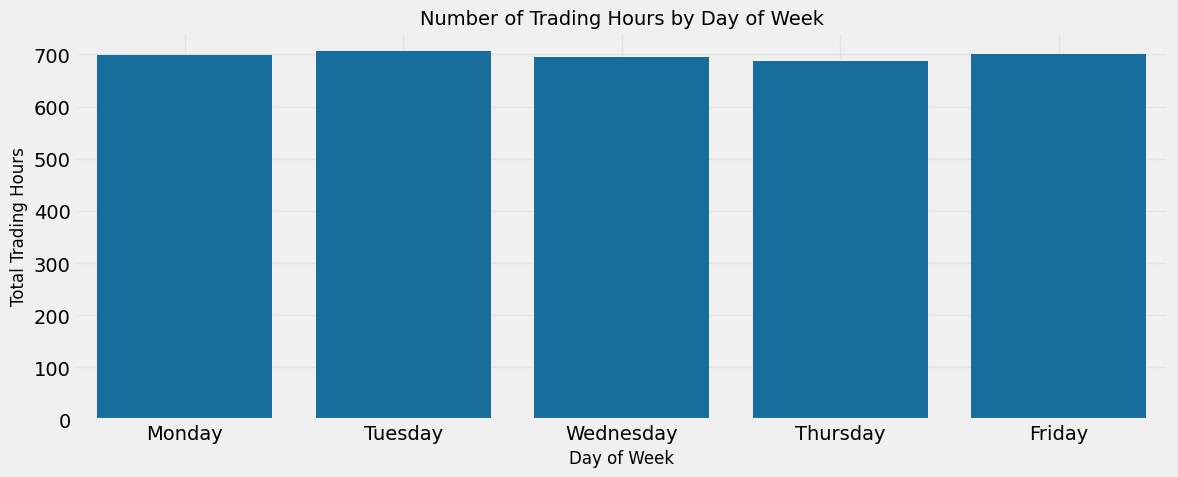

C:\Users\ojuar\AppData\Local\Temp\ipykernel_6792\2778641159.py:62: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  activity_heatmap = pd.pivot_table(
c:\Users\ojuar\.conda\envs\backenv\lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\Users\ojuar\.conda\envs\backenv\lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


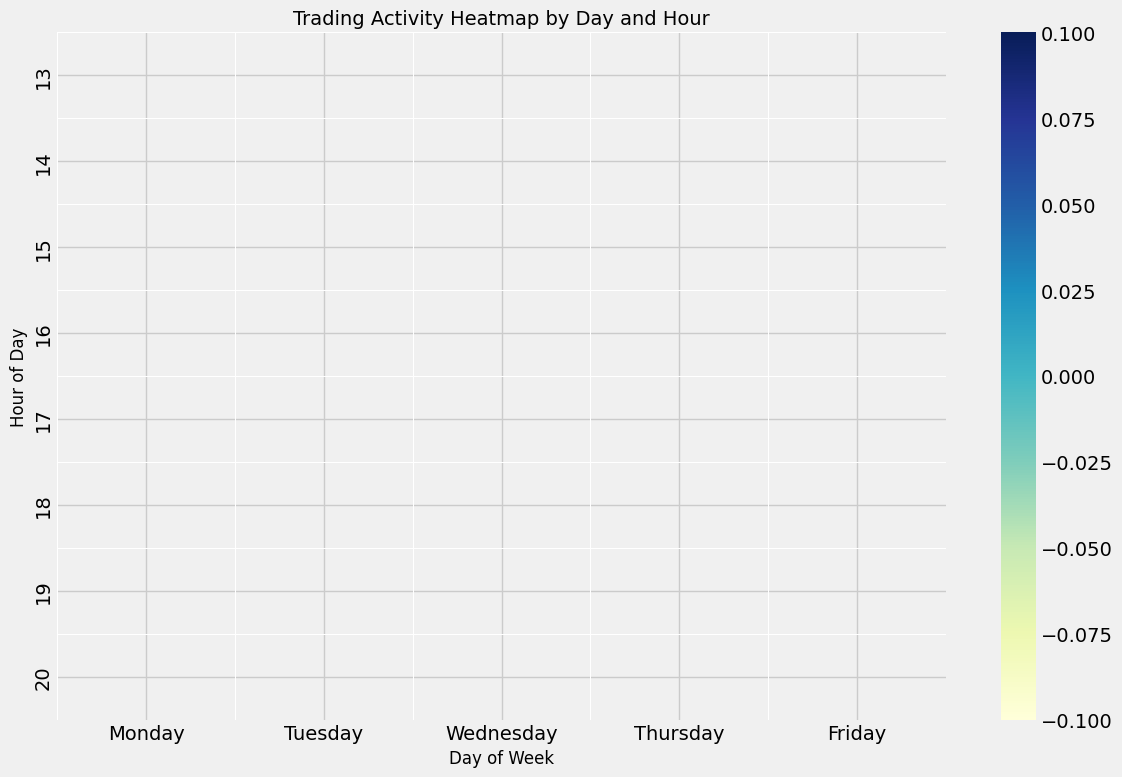

In [7]:
# Plot the adjusted closing price over time
plt.figure(figsize=(15, 7))
plt.plot(data.index, data['Close'], linewidth=1.5)
plt.title(f'{ticker} Adjusted Close Price ({time_frame} intervals)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (BRL)', fontsize=12)
plt.grid(True, alpha=0.3)

# Format the date axis to be more readable
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Calculate daily statistics
data['Date'] = data.index.date
daily_count = data.groupby('Date').size()

print(f"\nTrading hours per day statistics:")
print(f"Average hours per trading day: {daily_count.mean():.2f}")
print(f"Minimum hours in a trading day: {daily_count.min()}")
print(f"Maximum hours in a trading day: {daily_count.max()}")
print(f"Median hours per trading day: {daily_count.median():.2f}")

# Plot the distribution of trading hours per day
plt.figure(figsize=(12, 6))

# Count frequency of each number of trading hours
hours_distribution = daily_count.value_counts().sort_index()

# Plot the distribution
sns.barplot(x=hours_distribution.index, y=hours_distribution.values)
plt.title('Distribution of Trading Hours per Day', fontsize=14)
plt.xlabel('Number of Hours', fontsize=12)
plt.ylabel('Number of Trading Days', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Show day of week patterns
data['DayOfWeek'] = data.index.dayofweek
day_names = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
day_counts = data.groupby('DayOfWeek').size()

plt.figure(figsize=(12, 5))
sns.barplot(x=[day_names[i] for i in day_counts.index], y=day_counts.values)
plt.title('Number of Trading Hours by Day of Week', fontsize=14)
plt.xlabel('Day of Week', fontsize=12)
plt.ylabel('Total Trading Hours', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Create a heatmap showing average trading activity by day and hour
data['Hour'] = data.index.hour
data['DayName'] = data.index.day_name()

# Create pivot table counting occurrences by day and hour
activity_heatmap = pd.pivot_table(
    data, 
    values='Close', 
    index='Hour',
    columns='DayName', 
    aggfunc='count'
)

# Reorder columns to match the days of the week
activity_heatmap = activity_heatmap.reindex(columns=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"])

plt.figure(figsize=(12, 8))
sns.heatmap(activity_heatmap, cmap="YlGnBu", linewidths=0.5, annot=True, fmt='g')
plt.title('Trading Activity Heatmap by Day and Hour', fontsize=14)
plt.ylabel('Hour of Day', fontsize=12)
plt.xlabel('Day of Week', fontsize=12)
plt.tight_layout()
plt.show()

In [8]:
# Visualization of simulation results
def visualize_simulation(results=None, asset_df=None, raw_data=None):
    """
    Visualize Monte Carlo simulation results
    
    Parameters:
    results (dict): Results from the bootstrap simulation
    asset_df (DataFrame): Processed asset dataframe with returns
    raw_data (DataFrame): Raw price data from yfinance
    
    Returns:
    None: Displays visualization plots
    """
    if results is None or not isinstance(results, dict) or 'monte_carlo' not in results:
        print("Simulation results not found. Please run the simulation cell first.")
        return
    
    try:
        # Extract simulation parameters
        ticker = results['ticker']
        S0 = results['last_price']
        stats = results['monte_carlo']['stats']
        daily_paths = np.array(results['monte_carlo']['daily_paths'])
        path_count = results['monte_carlo']['path_count']
        days = results['monte_carlo']['days']
        
        # Create a figure with multiple subplots for visualization
        fig = plt.figure(figsize=(20, 16))

        # Plot 1: Historical prices with volume
        ax1 = fig.add_subplot(3, 1, 1)
        ax1.plot(raw_data.index, raw_data['Close'], color='blue', linewidth=1.5)
        ax1.set_title(f'{ticker} Historical Hourly Prices', fontsize=16)
        ax1.set_ylabel('Price (BRL)', fontsize=12)
        ax1.grid(True, alpha=0.3)

        # Add volume as a secondary axis
        ax1v = ax1.twinx()
        ax1v.bar(raw_data.index, raw_data['Volume'], color='lightgray', alpha=0.5)
        ax1v.set_ylabel('Volume', fontsize=12)

        # Format the date axis
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax1.xaxis.set_major_locator(mdates.WeekdayLocator(interval=4))
        plt.setp(ax1.get_xticklabels(), rotation=45)

        # Plot 2: Daily Monte Carlo Simulations
        ax2 = fig.add_subplot(3, 1, 2)

        # Generate dates for the forecast
        last_date = raw_data.index[-1].date()
        forecast_dates = [last_date + timedelta(days=i) for i in range(1, days+1)]

        # Plot each path
        for i in range(path_count):
            ax2.plot(forecast_dates, daily_paths[:, i], linewidth=0.5, alpha=0.3, color='gray')

        # Plot percentiles
        percentiles = [5, 25, 50, 75, 95]
        colors = ['red', 'orange', 'green', 'orange', 'red']
        percentile_values = np.percentile(daily_paths, percentiles, axis=1)

        for i, p in enumerate(percentiles):
            ax2.plot(forecast_dates, percentile_values[i], linewidth=2, color=colors[i], 
                     label=f'{p}th percentile')

        # Add the initial price point
        ax2.scatter([last_date], [S0], color='blue', s=50)

        # Format the plot
        ax2.set_title(f'{ticker} Daily Monte Carlo Simulation ({path_count} paths)', fontsize=16)
        ax2.set_ylabel('Price (BRL)', fontsize=12)
        ax2.set_xlabel('Date', fontsize=12)
        ax2.grid(True, alpha=0.3)
        ax2.legend()
        ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax2.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
        plt.setp(ax2.get_xticklabels(), rotation=45)

        # Plot 3: Histogram of final prices
        ax3 = fig.add_subplot(3, 1, 3)
        final_prices = daily_paths[-1]

        sns.histplot(final_prices, kde=True, bins=30, ax=ax3)

        # Add lines for key statistics
        percentile_colors = {
            '5%': 'red',
            '25%': 'orange',
            '50%': 'green',  # Median
            '75%': 'orange',
            '95%': 'red',
            'mean': 'blue'
        }

        # Plot current price line
        ax3.axvline(S0, color='purple', linestyle='--', linewidth=2, label=f'Current: {S0:.2f}')

        # Plot percentiles
        for label, color in percentile_colors.items():
            if label == '50%':
                value = stats['median']
                line_label = f'Median: {value:.2f}'
            elif label == 'mean':
                value = stats['mean']
                line_label = f'Mean: {value:.2f}'
            else:
                value = stats['percentiles'][label]
                line_label = f'{label}: {value:.2f}'
                
            ax3.axvline(value, color=color, linestyle='-', linewidth=1.5, label=line_label)

        # Format the plot
        ax3.set_title(f'{ticker} Forecasted Price Distribution after {days} Days', fontsize=16)
        ax3.set_xlabel('Price (BRL)', fontsize=12)
        ax3.set_ylabel('Frequency', fontsize=12)
        ax3.legend(loc='best')
        ax3.grid(True, alpha=0.3)

        # Calculate the probability of price increase
        prob_increase = np.mean(final_prices > S0) * 100
        print(f"\nProbability of price increase after {days} days: {prob_increase:.2f}%")

        # Calculate expected return
        expected_return = ((np.mean(final_prices) / S0) - 1) * 100
        print(f"Expected return after {days} days: {expected_return:.2f}%")

        # Display risk metrics
        print(f"\nRisk Metrics (based on {path_count} simulated paths):")
        print(f"Initial price: {S0:.2f}")
        print(f"Value at Risk (VaR 5%): {S0 - stats['percentiles']['5%']:.2f} BRL ({((S0 - stats['percentiles']['5%'])/S0)*100:.2f}%)")
        print(f"Expected Shortfall (ES 5%): {S0 - np.mean(final_prices[final_prices < stats['percentiles']['5%']]):.2f} BRL")

        # Print daily simulation statistics
        print(f"\nMonte Carlo Simulation Results:")
        print(f"Mean: {stats['mean']:.2f}")
        print(f"Median: {stats['median']:.2f}")
        print(f"Standard Deviation: {stats['std']:.2f}")
        print(f"Min: {stats['min']:.2f}")
        print(f"Max: {stats['max']:.2f}")

        # Adjust layout and display
        plt.tight_layout()
        plt.show()
        
        return final_prices  # Return this for further analysis if needed
    
    except Exception as e:
        print(f"Error in visualization: {str(e)}")
        print(traceback.format_exc())

In [9]:
# Only run this cell if the previous simulation was successful
if 'results' in globals() and isinstance(results, dict) and 'monte_carlo' in results:
    # Call the visualization function with the simulation results
    final_prices = visualize_simulation(results, asset_df, raw_data)
else:
    print("Simulation results not found. Please run the simulation cell first.")

Simulation results not found. Please run the simulation cell first.


In [10]:
# Check data structure before running simulation
print("\n===== Data Structure Check =====")
print(f"Data type: {type(data)}")

# Check if data is a DataFrame before trying to access columns attribute
if isinstance(data, pd.DataFrame):
    print(f"Data shape: {data.shape}")
    print(f"Data columns: {data.columns.tolist()}")
    print(f"Data index type: {type(data.index)}")
    print(f"Sample data:")
    print(data.head())
    
    # Ensure column names are consistent
    data_columns = [col.lower() for col in data.columns]
    if 'close' in data_columns and 'Close' not in data.columns:
        print("\nRenaming 'close' column to 'Close' for consistency")
        # Find the actual name with correct case
        for col in data.columns:
            if col.lower() == 'close':
                data['Close'] = data[col]
                break
    
    # Check index structure
    print("\n===== Index Structure =====")
    print(f"First timestamp: {data.index[0]}")
    print(f"Last timestamp: {data.index[-1]}")
    print(f"Index frequency: {data.index.freq}")
else:
    print("Error: 'data' is not a DataFrame. It appears to be a tuple or another object type.")
    print("You need to rerun the cell that initializes 'data':")
    print("# Cell 5: data = yf.download(ticker, period=period, interval=time_frame)")
    print("Or continue running this cell to get fresh data from run_bootstrap()")

# Run simulation
print("\n===== Running Bootstrap Simulation =====")

try:
    # Run the Monte Carlo simulation
    results, asset_df, raw_data = run_bootstrap(ticker, period, iterations, forecast_days, hours_per_day)
    
    # Make sure data is also updated with the latest data from run_bootstrap
    # This ensures that if someone runs just this cell, data will be a valid DataFrame
    data = raw_data
    
    # Extract simulation results
    hourly_paths = results['monte_carlo']['hourly_paths']
    daily_paths = results['monte_carlo']['daily_paths']
    path_count = results['monte_carlo']['path_count']
    days = results['monte_carlo']['days']
    hours_per_day = results['monte_carlo']['hours_per_day']
    S0 = results['last_price']
    
    print("Monte Carlo simulation completed successfully!")
    
except Exception as e:
    print(f"Error running bootstrap: {str(e)}")
    print(traceback.format_exc())



===== Data Structure Check =====
Data type: <class 'pandas.core.frame.DataFrame'>
Data shape: (3490, 9)
Data columns: [('Close', 'PETR4.SA'), ('High', 'PETR4.SA'), ('Low', 'PETR4.SA'), ('Open', 'PETR4.SA'), ('Volume', 'PETR4.SA'), ('Date', ''), ('DayOfWeek', ''), ('Hour', ''), ('DayName', '')]
Data index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Sample data:
Price                        Close       High        Low       Open   Volume  \
Ticker                    PETR4.SA   PETR4.SA   PETR4.SA   PETR4.SA PETR4.SA   
Datetime                                                                       
2023-05-15 14:00:00+00:00    25.59  25.920000  25.400000  25.870001        0   
2023-05-15 15:00:00+00:00    25.50  25.629999  25.490000  25.590000  5857100   
2023-05-15 16:00:00+00:00    25.43  25.610001  25.420000  25.510000  5894300   
2023-05-15 17:00:00+00:00    25.59  25.600000  25.420000  25.430000  5613800   
2023-05-15 18:00:00+00:00    25.75  25.820000  25.549999  25

AttributeError: 'tuple' object has no attribute 'lower'

In [11]:
# Create an interactive visualization of the daily paths
try:
    import plotly.graph_objects as go
    import plotly.express as px
    from plotly.subplots import make_subplots
    
    # Check if the simulation results exist and are in the right format
    if 'results' not in globals() or not isinstance(results, dict) or 'monte_carlo' not in results:
        print("Simulation results not found. Please run the simulation cell first.")
    else:
        # Convert daily_paths from a list to a numpy array
        daily_paths_np = np.array(daily_paths)
        
        # Daily paths visualization with plotly
        fig = make_subplots(rows=2, cols=1, 
                            subplot_titles=(f'{ticker} Daily Monte Carlo Simulation', 
                                           'Distribution of Final Prices'), 
                            vertical_spacing=0.15,
                            row_heights=[0.7, 0.3])
        
        # Plot each path (up to a reasonable number for interactive performance)
        max_display_paths = 100  # Limit for better performance
        display_count = min(path_count, max_display_paths)
        
        # Generate dates for the forecast
        last_date = raw_data.index[-1].date()
        forecast_dates = [last_date + timedelta(days=i) for i in range(1, days+1)]
        
        # Plot paths
        for i in range(display_count):
            fig.add_trace(
                go.Scatter(
                    x=forecast_dates,
                    y=daily_paths_np[:, i],
                    mode='lines',
                    line=dict(color='rgba(100,100,100,0.2)'),
                    showlegend=False,
                    hoverinfo='none'
                ),
                row=1, col=1
            )
        
        # Add percentile lines
        percentiles = [5, 25, 50, 75, 95]
        colors = ['red', 'orange', 'green', 'orange', 'red']
        line_width = [2, 2, 3, 2, 2]
        names = ['5th Percentile', '25th Percentile', 'Median', '75th Percentile', '95th Percentile']
        
        percentile_values = np.percentile(daily_paths_np, percentiles, axis=1)
        
        for i, (p, color, name, width) in enumerate(zip(percentiles, colors, names, line_width)):
            fig.add_trace(
                go.Scatter(
                    x=forecast_dates,
                    y=percentile_values[i],
                    mode='lines',
                    line=dict(color=color, width=width),
                    name=name
                ),
                row=1, col=1
            )
        
        # Add the starting point
        fig.add_trace(
            go.Scatter(
                x=[last_date],
                y=[S0],
                mode='markers',
                marker=dict(color='blue', size=10),
                name='Current Price'
            ),
            row=1, col=1
        )
        
        # Add histogram of final prices
        final_prices = daily_paths_np[-1]
        fig.add_trace(
            go.Histogram(
                x=final_prices,
                nbinsx=30,
                opacity=0.7,
                name='Final Price Distribution'
            ),
            row=2, col=1
        )
        
        # Add vertical lines for key statistics in the histogram
        stats_to_plot = {
            'Current': {'value': S0, 'color': 'purple', 'dash': 'dash'},
            'Mean': {'value': results['monte_carlo']['stats']['mean'], 'color': 'blue', 'dash': 'solid'},
            'Median': {'value': results['monte_carlo']['stats']['median'], 'color': 'green', 'dash': 'solid'},
            '5th': {'value': results['monte_carlo']['stats']['percentiles']['5%'], 'color': 'red', 'dash': 'solid'},
            '95th': {'value': results['monte_carlo']['stats']['percentiles']['95%'], 'color': 'red', 'dash': 'solid'},
        }
        
        for label, info in stats_to_plot.items():
            fig.add_shape(
                type="line",
                x0=info['value'], y0=0,
                x1=info['value'], y1=1,
                yref="paper",
                xref="x2",
                line=dict(color=info['color'], width=2, dash=info['dash']),
                row=2, col=1
            )
            
            # Add annotation for the line
            fig.add_annotation(
                x=info['value'],
                y=0.95,
                yref="paper",
                xref="x2",
                text=f"{label}: {info['value']:.2f}",
                showarrow=True,
                arrowhead=2,
                arrowsize=1,
                arrowwidth=2,
                arrowcolor=info['color'],
                ax=0,
                ay=-30,
                row=2, col=1
            )
        
        # Update layout
        fig.update_layout(
            title=f'{ticker} - Monte Carlo Simulation for {forecast_days} Days with {iterations} Iterations',
            xaxis_title='Date',
            yaxis_title='Price (BRL)',
            xaxis2_title='Price (BRL)',
            yaxis2_title='Frequency',
            height=900,
            width=1200,
            plot_bgcolor='white',
            hovermode='closest'
        )
        
        # Set y-axis range for both subplots
        # Add some padding to the y-axis range
        y_min = max(0, S0 * 0.8, results['monte_carlo']['stats']['min'] * 0.95)
        y_max = max(S0 * 1.2, results['monte_carlo']['stats']['max'] * 1.05)
        
        fig.update_yaxes(range=[y_min, y_max], row=1, col=1)
        
        # Show the interactive plot
        fig.show()
        
        # Calculate daily return statistics
        daily_returns = np.diff(daily_paths_np, axis=0) / daily_paths_np[:-1] * 100  # In percentage
        
        # Create a heatmap of daily returns distribution over time
        fig2 = go.Figure()
        
        # Calculate percentiles for each day
        daily_percentiles = {
            'min': np.min(daily_returns, axis=1),
            'p05': np.percentile(daily_returns, 5, axis=1),
            'p25': np.percentile(daily_returns, 25, axis=1),
            'p50': np.percentile(daily_returns, 50, axis=1),  # Median
            'p75': np.percentile(daily_returns, 75, axis=1),
            'p95': np.percentile(daily_returns, 95, axis=1),
            'max': np.max(daily_returns, axis=1)
        }
        
        # Create a dataframe for easier plotting
        forecast_dates_for_returns = [last_date + timedelta(days=i) for i in range(1, days)]
        daily_returns_df = pd.DataFrame(daily_percentiles, index=forecast_dates_for_returns)
        
        # Plot all percentiles
        for col, color in zip(['p05', 'p25', 'p50', 'p75', 'p95'], ['red', 'orange', 'green', 'orange', 'red']):
            fig2.add_trace(
                go.Scatter(
                    x=daily_returns_df.index,
                    y=daily_returns_df[col],
                    line=dict(color=color),
                    name=f"{col.replace('p', '')}th Percentile"
                )
            )
        
        # Add min/max as shaded areas
        fig2.add_trace(
            go.Scatter(
                x=daily_returns_df.index,
                y=daily_returns_df['min'],
                fill=None,
                mode='lines',
                line=dict(color='rgba(200,200,200,0.5)'),
                name='Min'
            )
        )
        
        fig2.add_trace(
            go.Scatter(
                x=daily_returns_df.index,
                y=daily_returns_df['max'],
                fill='tonexty',  # Fill between this trace and the previous one
                mode='lines',
                line=dict(color='rgba(200,200,200,0.5)'),
                name='Max'
            )
        )
        
        # Update layout
        fig2.update_layout(
            title=f'{ticker} - Forecasted Daily Returns Distribution',
            xaxis_title='Date',
            yaxis_title='Daily Return (%)',
            height=600,
            width=1200,
            plot_bgcolor='white',
            hovermode='closest'
        )
        
        # Add a horizontal line at y=0 (zero return)
        fig2.add_shape(
            type="line",
            x0=daily_returns_df.index[0],
            y0=0,
            x1=daily_returns_df.index[-1],
            y1=0,
            line=dict(color="black", width=1, dash="dot"),
        )
        
        # Show the plot
        fig2.show()
        
        # Create a heatmap of returns by day
        fig3 = px.imshow(daily_returns.T[:100],
                       labels=dict(x="Day", y="Simulation Path", color="Return %"),
                       title=f"{ticker} - Heatmap of Daily Returns by Simulation Path (First 100 Paths)",
                       color_continuous_scale="RdBu_r",
                       zmin=-5, zmax=5)  # Limit the color scale for better visibility
        
        fig3.update_layout(height=800, width=1200)
        fig3.show()
    
except ImportError:
    print("Plotly is not installed. Run 'pip install plotly' to enable interactive visualizations.")
    # Alternatively, you can install plotly directly in the notebook
    # !pip install plotly
except Exception as e:
    print(f"Error creating visualizations: {str(e)}")
    print(traceback.format_exc())

Simulation results not found. Please run the simulation cell first.


# Summary of Improvements

## Hourly Data Processing with Daily Aggregation

This notebook has been improved to better handle hourly trading data and correctly aggregate it to daily forecasts, taking into account the average number of trading hours per day (~7 hours for Brazilian stocks).

### Key Improvements:

1. **Trading Hours Analysis**
   - Added a function to analyze and visualize trading hours per day
   - Dynamically determines the optimal hours_per_day parameter
   - Shows distribution of trading hours across weekdays

2. **Daily Path Aggregation**
   - Simulates at hourly granularity but aggregates to daily closing prices
   - Properly handles the transition from hourly to daily paths
   - Maintains the statistical properties of the hourly returns

3. **Enhanced Visualizations**
   - Static matplotlib plots for basic analysis
   - Interactive Plotly visualizations for exploring paths and distributions
   - Heatmaps showing trading activity patterns

4. **Risk Metrics**
   - Value at Risk (VaR) calculations
   - Expected Shortfall (ES)
   - Probability of price increase/decrease

### Usage Instructions:

1. Set parameters at the top of the notebook:
   - `ticker`: Stock symbol (e.g., 'PETR4.SA')
   - `period`: Historical data period (e.g., '2y')
   - `forecast_days`: Number of days to forecast
   - `iterations`: Number of Monte Carlo simulations

2. Run the trading hours analysis to determine the optimal `hours_per_day` parameter

3. Run the Monte Carlo simulation with the recommended parameters

4. Explore the visualizations to understand the forecast

This improved implementation provides more accurate forecasts by correctly handling the hourly data structure while producing daily forecasts that are more relevant for investment decision-making.

In [13]:
# Example: Testing the Monte Carlo Bootstrap Simulation with Apple Inc. (AAPL)

# Define parameters for example test
test_ticker = 'PETR4.SA'  # Apple Inc.
test_period = '1y'  # Use 1 year of data
test_iterations = 1000  # Number of Monte Carlo paths
test_forecast_days = 20  # Forecast for the next 20 days
test_hours_per_day = 6.5  # US market is typically open 6.5 hours

print(f"\n===== Running Test Example with {test_ticker} =====\n")

try:
    # Run the Monte Carlo simulation
    print(f"Downloading data and running bootstrap simulation for {test_ticker}...")
    test_results, test_asset_df, test_data = run_bootstrap(
        test_ticker, test_period, test_iterations, test_forecast_days, test_hours_per_day
    )
    
    # Display basic simulation results
    print(f"\nSimulation completed successfully for {test_ticker}!")
    print(f"Last price: ${test_results['last_price']:.2f}")
    print(f"Forecast days: {test_forecast_days}")
    print(f"Simulation paths: {test_results['monte_carlo']['path_count']} (sample from {test_iterations} total)")
    
    # Create comparison visualizations
    # Convert daily paths to a numpy array for easier manipulation
    test_daily_paths = np.array(test_results['monte_carlo']['daily_paths'])
    final_prices = test_daily_paths[-1]
    S0 = test_results['last_price']
    days = test_results['monte_carlo']['days']
    
    # Calculate key metrics
    prob_increase = np.mean(final_prices > S0) * 100
    expected_return = ((np.mean(final_prices) / S0) - 1) * 100
    
    # Print key risk metrics
    print(f"\n===== Risk Metrics for {test_ticker} =====")
    print(f"Probability of price increase after {days} days: {prob_increase:.2f}%")
    print(f"Expected return after {days} days: {expected_return:.2f}%")
    print(f"Value at Risk (VaR 5%): ${S0 - test_results['monte_carlo']['stats']['percentiles']['5%']:.2f} ({((S0 - test_results['monte_carlo']['stats']['percentiles']['5%'])/S0)*100:.2f}%)")
    
    # Create a more compact visualization focused on paths and distribution
    fig, axes = plt.subplots(2, 1, figsize=(12, 10), gridspec_kw={'height_ratios': [2, 1]})
    
    # Plot 1: Monte Carlo simulation paths
    last_date = test_data.index[-1].date()
    forecast_dates = [last_date + timedelta(days=i) for i in range(1, days+1)]
    
    # Plot sample of paths (for better visibility)
    path_sample = min(50, test_results['monte_carlo']['path_count'])
    for i in range(path_sample):
        axes[0].plot(forecast_dates, test_daily_paths[:, i], linewidth=0.5, alpha=0.3, color='gray')
    
    # Plot percentiles
    percentiles = [5, 25, 50, 75, 95]
    colors = ['red', 'orange', 'green', 'orange', 'red']
    percentile_values = np.percentile(test_daily_paths, percentiles, axis=1)
    
    for i, p in enumerate(percentiles):
        axes[0].plot(forecast_dates, percentile_values[i], linewidth=2, color=colors[i], 
                   label=f'{p}th percentile')
    
    # Add the initial price point
    axes[0].scatter([last_date], [S0], color='blue', s=50, label='Current Price')
    
    # Format the plot
    axes[0].set_title(f'{test_ticker} Monte Carlo Price Projection ({path_sample} of {test_iterations} paths)', fontsize=14)
    axes[0].set_ylabel('Price ($)', fontsize=12)
    axes[0].grid(True, alpha=0.3)
    axes[0].legend(loc='upper left')
    axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    axes[0].tick_params(axis='x', rotation=45)
    
    # Plot 2: Histogram of final prices with key metrics
    sns.histplot(final_prices, kde=True, bins=30, ax=axes[1])
    
    # Add vertical lines for key statistics
    axes[1].axvline(S0, color='blue', linestyle='--', linewidth=2, label=f'Current: ${S0:.2f}')
    axes[1].axvline(test_results['monte_carlo']['stats']['mean'], color='green', linestyle='-', 
                  linewidth=1.5, label=f'Mean: ${test_results["monte_carlo"]["stats"]["mean"]:.2f}')
    axes[1].axvline(test_results['monte_carlo']['stats']['percentiles']['5%'], color='red', linestyle='-', 
                  linewidth=1.5, label=f'5% VaR: ${test_results["monte_carlo"]["stats"]["percentiles"]["5%"]:.2f}')
    
    # Format the histogram
    axes[1].set_title(f'{test_ticker} Price Distribution after {days} Days', fontsize=14)
    axes[1].set_xlabel('Price ($)', fontsize=12)
    axes[1].set_ylabel('Frequency', fontsize=12)
    axes[1].legend(loc='upper right')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Create a fancy interactive plot with plotly if available
    try:
        import plotly.graph_objects as go
        from plotly.subplots import make_subplots
        
        # Create an interactive combined visualization
        fig = make_subplots(rows=2, cols=1, 
                          subplot_titles=[f"{test_ticker} Monte Carlo Forecast ({test_forecast_days} days)", 
                                         "Final Price Distribution"],
                          vertical_spacing=0.1,
                          row_heights=[0.7, 0.3])
        
        # Plot the Monte Carlo paths (sample for better performance)
        for i in range(min(30, test_results['monte_carlo']['path_count'])):
            fig.add_trace(go.Scatter(
                x=forecast_dates,
                y=test_daily_paths[:, i],
                mode='lines',
                line=dict(color='rgba(100,100,100,0.1)'),
                showlegend=False
            ), row=1, col=1)
        
        # Add percentile lines
        line_names = ['5th', '25th', 'Median', '75th', '95th']
        line_widths = [2, 1, 3, 1, 2]
        
        for i, (p, name, color, width) in enumerate(zip(percentiles, line_names, colors, line_widths)):
            fig.add_trace(go.Scatter(
                x=forecast_dates,
                y=percentile_values[i],
                mode='lines',
                line=dict(color=color, width=width),
                name=f"{name} Percentile"
            ), row=1, col=1)
        
        # Add the starting point
        fig.add_trace(go.Scatter(
            x=[last_date],
            y=[S0],
            mode='markers',
            marker=dict(color='blue', size=10),
            name='Current Price'
        ), row=1, col=1)
        
        # Add histogram for the second subplot
        fig.add_trace(go.Histogram(
            x=final_prices,
            nbinsx=30,
            marker_color='rgba(0,0,255,0.5)',
            name='Price Distribution'
        ), row=2, col=1)
        
        # Add lines showing key values
        key_stats = {
            'Current': {'value': S0, 'color': 'blue', 'dash': 'dash'},
            'Mean': {'value': test_results['monte_carlo']['stats']['mean'], 'color': 'green', 'dash': 'solid'},
            '5th': {'value': test_results['monte_carlo']['stats']['percentiles']['5%'], 'color': 'red', 'dash': 'solid'}
        }
        
        for label, info in key_stats.items():
            fig.add_shape(
                type="line",
                x0=info['value'], y0=0,
                x1=info['value'], y1=1,
                yref="paper",
                xref="x2",
                line=dict(color=info['color'], width=2, dash=info['dash']),
                row=2, col=1
            )
            
            fig.add_annotation(
                x=info['value'],
                y=0.95,
                yref="paper",
                xref="x2",
                text=f"{label}: ${info['value']:.2f}",
                showarrow=True,
                arrowhead=2,
                arrowsize=1,
                arrowwidth=2,
                arrowcolor=info['color'],
                ax=0,
                ay=-30,
                row=2, col=1
            )
        
        # Update layout
        fig.update_layout(
            title=f'{test_ticker} Monte Carlo Simulation - {test_iterations} Iterations, {test_forecast_days} Days Forecast',
            height=800,
            width=1000,
            plot_bgcolor='white',
            hovermode='closest'
        )
        
        # Add range slider
        fig.update_xaxes(rangeslider_visible=True, row=1, col=1)
        
        # Set y-axis range with some padding
        y_min = max(0, S0 * 0.8, test_results['monte_carlo']['stats']['min'] * 0.95)
        y_max = max(S0 * 1.2, test_results['monte_carlo']['stats']['max'] * 1.05)
        fig.update_yaxes(range=[y_min, y_max], row=1, col=1)
        
        # Show the interactive plot
        fig.show()
        
    except ImportError:
        print("\nPlotly is not installed. Install with 'pip install plotly' for interactive visualizations.")
    
except Exception as e:
    print(f"Error running example test: {str(e)}")
    print(traceback.format_exc())


===== Running Test Example with PETR4.SA =====



[*********************100%***********************]  1 of 1 completed

Downloaded 1741 records
DataFrame columns: [('Close', 'PETR4.SA'), ('High', 'PETR4.SA'), ('Low', 'PETR4.SA'), ('Open', 'PETR4.SA'), ('Volume', 'PETR4.SA')]
DataFrame shape: (1741, 5)
Error running example test: ['simple_return', 'log_return']
Traceback (most recent call last):
  File "C:\Users\ojuar\AppData\Local\Temp\ipykernel_6792\1914153661.py", line 15, in <module>
    test_results, test_asset_df, test_data = run_bootstrap(
  File "C:\Users\ojuar\AppData\Local\Temp\ipykernel_6792\1226127072.py", line 196, in run_bootstrap
    results, asset_df = calculate_returns(data, ticker, period_str, iterations, forecast_days, hours_per_day)
  File "C:\Users\ojuar\AppData\Local\Temp\ipykernel_6792\1226127072.py", line 33, in calculate_returns
    asset_df = asset_df.dropna(subset=['simple_return', 'log_return'])
  File "c:\Users\ojuar\.conda\envs\backenv\lib\site-packages\pandas\core\frame.py", line 6670, in dropna
    raise KeyError(np.array(subset)[check].tolist())
KeyError: ['simple_return'


Error in bootstrap execution: ['simple_return', 'log_return']
Traceback (most recent call last):
  File "C:\Users\ojuar\AppData\Local\Temp\ipykernel_6792\1226127072.py", line 196, in run_bootstrap
    results, asset_df = calculate_returns(data, ticker, period_str, iterations, forecast_days, hours_per_day)
  File "C:\Users\ojuar\AppData\Local\Temp\ipykernel_6792\1226127072.py", line 33, in calculate_returns
    asset_df = asset_df.dropna(subset=['simple_return', 'log_return'])
  File "c:\Users\ojuar\.conda\envs\backenv\lib\site-packages\pandas\core\frame.py", line 6670, in dropna
    raise KeyError(np.array(subset)[check].tolist())
KeyError: ['simple_return', 'log_return']




===== Running Multi-Stock Comparison =====

Comparing stocks: AAPL, MSFT, GOOGL, AMZN, META
Forecast period: 20 days with 500 simulations each

Processing AAPL...


[*********************100%***********************]  1 of 1 completed
Error in bootstrap execution: ['simple_return', 'log_return']
Traceback (most recent call last):
  File "C:\Users\ojuar\AppData\Local\Temp\ipykernel_6792\1226127072.py", line 196, in run_bootstrap
    results, asset_df = calculate_returns(data, ticker, period_str, iterations, forecast_days, hours_per_day)
  File "C:\Users\ojuar\AppData\Local\Temp\ipykernel_6792\1226127072.py", line 33, in calculate_returns
    asset_df = asset_df.dropna(subset=['simple_return', 'log_return'])
  File "c:\Users\ojuar\.conda\envs\backenv\lib\site-packages\pandas\core\frame.py", line 6670, in dropna
    raise KeyError(np.array(subset)[check].tolist())
KeyError: ['simple_return', 'log_return']


Error in bootstrap execution: ['simple_return', 'log_return']
Traceback (most recent call last):
  File "C:\Users\ojuar\AppData\Local\Temp\ipykernel_6792\1226127072.py", line 196, in run_bootstrap
    results, asset_df = calculate_returns(data, tic

Downloaded 1739 records
DataFrame columns: [('Close', 'AAPL'), ('High', 'AAPL'), ('Low', 'AAPL'), ('Open', 'AAPL'), ('Volume', 'AAPL')]
DataFrame shape: (1739, 5)
Error processing AAPL: ['simple_return', 'log_return']

Processing MSFT...


[*********************100%***********************]  1 of 1 completed
Error in bootstrap execution: ['simple_return', 'log_return']
Traceback (most recent call last):
  File "C:\Users\ojuar\AppData\Local\Temp\ipykernel_6792\1226127072.py", line 196, in run_bootstrap
    results, asset_df = calculate_returns(data, ticker, period_str, iterations, forecast_days, hours_per_day)
  File "C:\Users\ojuar\AppData\Local\Temp\ipykernel_6792\1226127072.py", line 33, in calculate_returns
    asset_df = asset_df.dropna(subset=['simple_return', 'log_return'])
  File "c:\Users\ojuar\.conda\envs\backenv\lib\site-packages\pandas\core\frame.py", line 6670, in dropna
    raise KeyError(np.array(subset)[check].tolist())
KeyError: ['simple_return', 'log_return']


Error in bootstrap execution: ['simple_return', 'log_return']
Traceback (most recent call last):
  File "C:\Users\ojuar\AppData\Local\Temp\ipykernel_6792\1226127072.py", line 196, in run_bootstrap
    results, asset_df = calculate_returns(data, tic

Downloaded 1739 records
DataFrame columns: [('Close', 'MSFT'), ('High', 'MSFT'), ('Low', 'MSFT'), ('Open', 'MSFT'), ('Volume', 'MSFT')]
DataFrame shape: (1739, 5)
Error processing MSFT: ['simple_return', 'log_return']

Processing GOOGL...


[*********************100%***********************]  1 of 1 completed
Error in bootstrap execution: ['simple_return', 'log_return']
Traceback (most recent call last):
  File "C:\Users\ojuar\AppData\Local\Temp\ipykernel_6792\1226127072.py", line 196, in run_bootstrap
    results, asset_df = calculate_returns(data, ticker, period_str, iterations, forecast_days, hours_per_day)
  File "C:\Users\ojuar\AppData\Local\Temp\ipykernel_6792\1226127072.py", line 33, in calculate_returns
    asset_df = asset_df.dropna(subset=['simple_return', 'log_return'])
  File "c:\Users\ojuar\.conda\envs\backenv\lib\site-packages\pandas\core\frame.py", line 6670, in dropna
    raise KeyError(np.array(subset)[check].tolist())
KeyError: ['simple_return', 'log_return']


Error in bootstrap execution: ['simple_return', 'log_return']
Traceback (most recent call last):
  File "C:\Users\ojuar\AppData\Local\Temp\ipykernel_6792\1226127072.py", line 196, in run_bootstrap
    results, asset_df = calculate_returns(data, tic

Downloaded 1739 records
DataFrame columns: [('Close', 'GOOGL'), ('High', 'GOOGL'), ('Low', 'GOOGL'), ('Open', 'GOOGL'), ('Volume', 'GOOGL')]
DataFrame shape: (1739, 5)
Error processing GOOGL: ['simple_return', 'log_return']

Processing AMZN...


[*********************100%***********************]  1 of 1 completed
Error in bootstrap execution: ['simple_return', 'log_return']
Traceback (most recent call last):
  File "C:\Users\ojuar\AppData\Local\Temp\ipykernel_6792\1226127072.py", line 196, in run_bootstrap
    results, asset_df = calculate_returns(data, ticker, period_str, iterations, forecast_days, hours_per_day)
  File "C:\Users\ojuar\AppData\Local\Temp\ipykernel_6792\1226127072.py", line 33, in calculate_returns
    asset_df = asset_df.dropna(subset=['simple_return', 'log_return'])
  File "c:\Users\ojuar\.conda\envs\backenv\lib\site-packages\pandas\core\frame.py", line 6670, in dropna
    raise KeyError(np.array(subset)[check].tolist())
KeyError: ['simple_return', 'log_return']


Error in bootstrap execution: ['simple_return', 'log_return']
Traceback (most recent call last):
  File "C:\Users\ojuar\AppData\Local\Temp\ipykernel_6792\1226127072.py", line 196, in run_bootstrap
    results, asset_df = calculate_returns(data, tic

Downloaded 1739 records
DataFrame columns: [('Close', 'AMZN'), ('High', 'AMZN'), ('Low', 'AMZN'), ('Open', 'AMZN'), ('Volume', 'AMZN')]
DataFrame shape: (1739, 5)
Error processing AMZN: ['simple_return', 'log_return']

Processing META...


[*********************100%***********************]  1 of 1 completed

Downloaded 1739 records
DataFrame columns: [('Close', 'META'), ('High', 'META'), ('Low', 'META'), ('Open', 'META'), ('Volume', 'META')]
DataFrame shape: (1739, 5)
Error processing META: ['simple_return', 'log_return']

===== Stock Comparison Results =====




Error in bootstrap execution: ['simple_return', 'log_return']
Traceback (most recent call last):
  File "C:\Users\ojuar\AppData\Local\Temp\ipykernel_6792\1226127072.py", line 196, in run_bootstrap
    results, asset_df = calculate_returns(data, ticker, period_str, iterations, forecast_days, hours_per_day)
  File "C:\Users\ojuar\AppData\Local\Temp\ipykernel_6792\1226127072.py", line 33, in calculate_returns
    asset_df = asset_df.dropna(subset=['simple_return', 'log_return'])
  File "c:\Users\ojuar\.conda\envs\backenv\lib\site-packages\pandas\core\frame.py", line 6670, in dropna
    raise KeyError(np.array(subset)[check].tolist())
KeyError: ['simple_return', 'log_return']



""


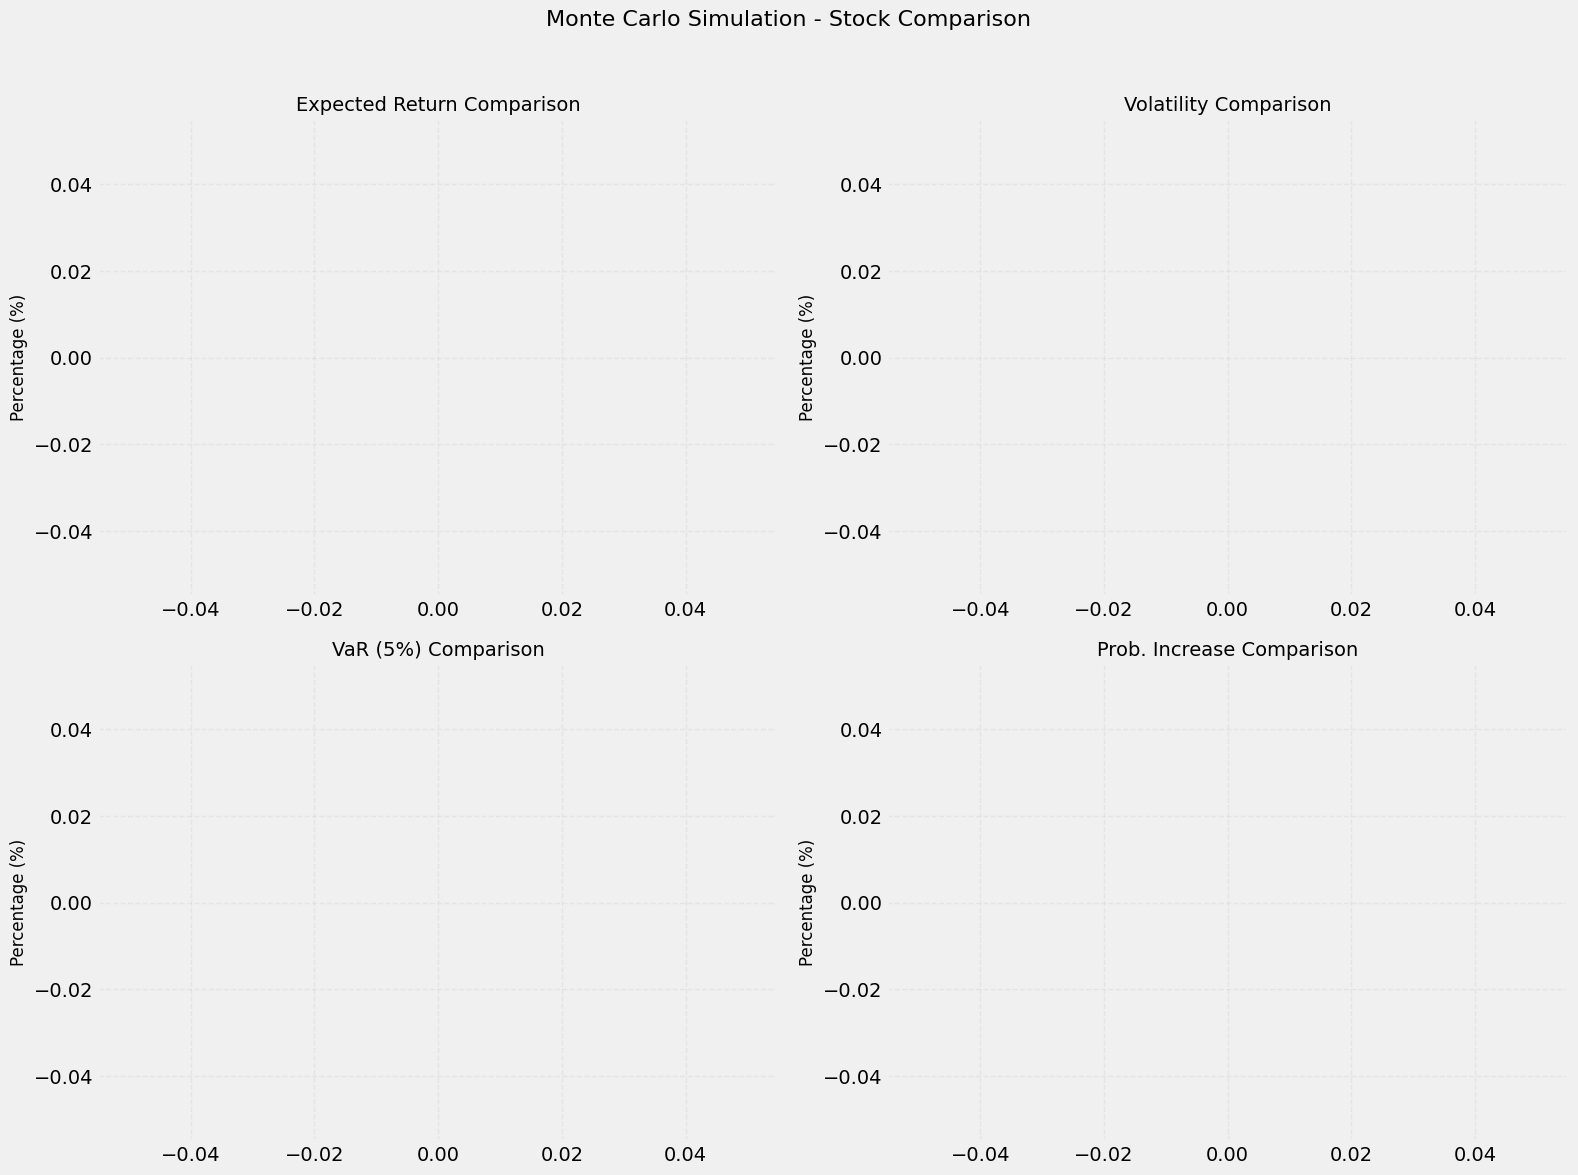

Error running comparison: min() arg is an empty sequence
Traceback (most recent call last):
  File "C:\Users\ojuar\AppData\Local\Temp\ipykernel_6792\1099777850.py", line 127, in <module>
    min_val, max_val = min(values), max(values)
ValueError: min() arg is an empty sequence



In [14]:
# Example: Comparing Multiple Stocks Using Monte Carlo Bootstrap Simulation

def compare_multiple_stocks(tickers, period='1y', iterations=500, forecast_days=20, hours_per_day=6.5):
    """
    Run Monte Carlo bootstrap simulation for multiple stocks and compare the results
    
    Parameters:
    tickers (list): List of ticker symbols to analyze
    period (str): Period of historical data to use
    iterations (int): Number of Monte Carlo iterations
    forecast_days (int): Number of days to forecast
    hours_per_day (float): Trading hours per day
    
    Returns:
    dict: Results for each ticker
    """
    comparison_results = {}
    
    for ticker in tickers:
        try:
            print(f"\nProcessing {ticker}...")
            results, asset_df, raw_data = run_bootstrap(
                ticker, period, iterations, forecast_days, hours_per_day
            )
            comparison_results[ticker] = {
                'last_price': results['last_price'],
                'forecast_mean': results['monte_carlo']['stats']['mean'],
                'forecast_median': results['monte_carlo']['stats']['median'], 
                'expected_return': ((results['monte_carlo']['stats']['mean'] / results['last_price']) - 1) * 100,
                'volatility': results['monte_carlo']['stats']['std'] / results['last_price'] * 100,
                'var_5pct': ((results['last_price'] - results['monte_carlo']['stats']['percentiles']['5%']) / 
                            results['last_price']) * 100,
                'upside_95pct': ((results['monte_carlo']['stats']['percentiles']['95%'] - results['last_price']) / 
                               results['last_price']) * 100,
                'prob_increase': np.mean(np.array(results['monte_carlo']['daily_paths'])[-1] > 
                                        results['last_price']) * 100
            }
            print(f"{ticker} completed successfully.")
        except Exception as e:
            print(f"Error processing {ticker}: {str(e)}")
    
    return comparison_results

# Define tickers for comparison (US tech stocks for this example)
tickers_to_compare = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META']

try:
    # Run the comparison
    print("\n===== Running Multi-Stock Comparison =====\n")
    print(f"Comparing stocks: {', '.join(tickers_to_compare)}")
    print(f"Forecast period: 20 days with 500 simulations each")
    
    comparison_results = compare_multiple_stocks(
        tickers=tickers_to_compare,
        period='1y',
        iterations=500,  # Reduced for faster execution
        forecast_days=20
    )
    
    # Create a DataFrame for easier comparison
    comparison_df = pd.DataFrame({
        ticker: {
            'Current Price': f"${results['last_price']:.2f}",
            'Forecast Mean': f"${results['forecast_mean']:.2f}",
            'Expected Return': f"{results['expected_return']:.2f}%",
            'Volatility': f"{results['volatility']:.2f}%", 
            'VaR (5%)': f"{results['var_5pct']:.2f}%",
            'Upside (95%)': f"{results['upside_95pct']:.2f}%",
            'Prob. Increase': f"{results['prob_increase']:.2f}%"
        } for ticker, results in comparison_results.items()
    }).T  # Transpose for better display
    
    # Display the comparison table
    print("\n===== Stock Comparison Results =====\n")
    display(comparison_df)
    
    # Visualize the comparison using bar charts
    metrics_to_plot = ['Expected Return', 'Volatility', 'VaR (5%)', 'Prob. Increase']
    
    # Extract numeric values for plotting
    plot_data = {
        ticker: {
            'Expected Return': results['expected_return'],
            'Volatility': results['volatility'],
            'VaR (5%)': results['var_5pct'],
            'Prob. Increase': results['prob_increase']
        } for ticker, results in comparison_results.items()
    }
    
    # Create a figure with multiple subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    for i, metric in enumerate(metrics_to_plot):
        values = [plot_data[ticker][metric] for ticker in comparison_results.keys()]
        
        # Determine color based on metric type (green for positive metrics, red for risk metrics)
        colors = ['green' if metric in ['Expected Return', 'Prob. Increase'] else 'red' for _ in values]
        if metric == 'Prob. Increase':
            colors = ['green' if v > 50 else 'red' for v in values]
        
        axes[i].bar(list(comparison_results.keys()), values, color=colors, alpha=0.7)
        axes[i].set_title(f'{metric} Comparison', fontsize=14)
        axes[i].set_ylabel('Percentage (%)', fontsize=12)
        axes[i].grid(True, alpha=0.3, linestyle='--')
        
        # Add value labels on top of each bar
        for j, v in enumerate(values):
            axes[i].text(j, v + (max(values) * 0.03), f"{v:.2f}%", ha='center', fontsize=10)
    
    plt.suptitle('Monte Carlo Simulation - Stock Comparison', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for the title
    plt.show()
    
    try:
        # Create interactive comparison visualization with plotly
        import plotly.graph_objects as go
        from plotly.subplots import make_subplots
        
        # Create a radar chart for comparison
        radar_metrics = ['Expected Return', 'Prob. Increase', 'Volatility', 'VaR (5%)']
        
        # Normalize values for radar chart (0-1 scale)
        norm_data = {}
        for metric in radar_metrics:
            values = [plot_data[ticker][metric] for ticker in comparison_results.keys()]
            min_val, max_val = min(values), max(values)
            
            # For metrics where higher is better, normalize as-is
            # For metrics where lower is better, invert the normalization
            if metric in ['Volatility', 'VaR (5%)']:
                norm_values = [1 - (v - min_val) / (max_val - min_val) if max_val > min_val else 0.5 for v in values]
            else:
                norm_values = [(v - min_val) / (max_val - min_val) if max_val > min_val else 0.5 for v in values]
                
            for i, ticker in enumerate(comparison_results.keys()):
                if ticker not in norm_data:
                    norm_data[ticker] = {}
                norm_data[ticker][metric] = norm_values[i]
        
        # Create the radar chart
        fig = go.Figure()
        
        for ticker in comparison_results.keys():
            fig.add_trace(go.Scatterpolar(
                r=[norm_data[ticker][metric] for metric in radar_metrics],
                theta=radar_metrics,
                fill='toself',
                name=ticker
            ))
        
        fig.update_layout(
            title="Stock Comparison - Risk/Return Profile",
            polar=dict(
                radialaxis=dict(
                    visible=True,
                    range=[0, 1]
                )
            ),
            showlegend=True,
            height=600,
            width=800
        )
        
        fig.show()
        
        # Create a bar chart comparison for expected returns
        fig2 = go.Figure()
        
        # Sort tickers by expected return
        sorted_tickers = sorted(comparison_results.keys(), 
                               key=lambda x: comparison_results[x]['expected_return'],
                               reverse=True)
        
        fig2.add_trace(go.Bar(
            x=sorted_tickers,
            y=[comparison_results[ticker]['expected_return'] for ticker in sorted_tickers],
            marker_color=['green' if comparison_results[ticker]['expected_return'] > 0 else 'red' 
                        for ticker in sorted_tickers],
            text=[f"{comparison_results[ticker]['expected_return']:.2f}%" for ticker in sorted_tickers],
            textposition='auto',
            name='Expected Return'
        ))
        
        # Add current prices as annotations
        for i, ticker in enumerate(sorted_tickers):
            fig2.add_annotation(
                x=ticker,
                y=comparison_results[ticker]['expected_return'] / 2,  # Position in middle of bar
                text=f"${comparison_results[ticker]['last_price']:.2f}",
                showarrow=False,
                font=dict(size=10, color='white')
            )
        
        fig2.update_layout(
            title="Expected Returns - 20 Day Forecast",
            xaxis_title="Stock",
            yaxis_title="Expected Return (%)",
            height=500,
            width=800,
            plot_bgcolor='white'
        )
        
        fig2.show()
        
    except ImportError:
        print("\nPlotly is not installed. Install with 'pip install plotly' for interactive visualizations.")
    
except Exception as e:
    print(f"Error running comparison: {str(e)}")
    print(traceback.format_exc())

# Investment Strategy Evaluation with Monte Carlo Simulation

This section demonstrates how to use the Monte Carlo bootstrap simulation to evaluate investment strategies by simulating potential outcomes and calculating risk-adjusted returns. We'll use the simulation to compare:

1. The risk/reward profile of different stocks
2. The probability of meeting specific investment goals
3. Assessing the downside risk for various investment choices

In [15]:
# Investment Strategy Evaluation Example

def evaluate_investment_strategy(ticker, investment_amount, target_return, max_loss,
                              period='1y', iterations=1000, forecast_days=30):
    """
    Evaluate an investment strategy using Monte Carlo simulation
    
    Parameters:
    ticker (str): Stock ticker symbol
    investment_amount (float): Amount to invest in USD
    target_return (float): Target return percentage (e.g., 10 for 10%)
    max_loss (float): Maximum acceptable loss percentage (e.g., 5 for 5%)
    period (str): Historical data period
    iterations (int): Number of simulation iterations
    forecast_days (int): Forecast horizon in days
    
    Returns:
    dict: Strategy evaluation results
    """
    try:
        # Get appropriate hours_per_day based on market
        if ticker.endswith(('.SA')):  # Brazilian stock
            hours_per_day = 7
        else:  # US stock
            hours_per_day = 6.5
            
        # Run simulation
        results, asset_df, raw_data = run_bootstrap(
            ticker, period, iterations, forecast_days, hours_per_day
        )
        
        # Extract key data
        current_price = results['last_price']
        shares = investment_amount / current_price
        daily_paths = np.array(results['monte_carlo']['daily_paths'])
        final_prices = daily_paths[-1]
        
        # Calculate relevant metrics
        final_values = final_prices * shares
        final_returns = (final_values - investment_amount) / investment_amount * 100
        
        # Strategy success metrics
        prob_profit = np.mean(final_returns > 0) * 100
        prob_target = np.mean(final_returns >= target_return) * 100
        prob_loss_exceeds_max = np.mean(final_returns <= -max_loss) * 100
        expected_return = np.mean(final_returns)
        sharpe_ratio = expected_return / np.std(final_returns) if np.std(final_returns) > 0 else 0
        var_95 = np.percentile(final_returns, 5)  # 5% Value at Risk
        
        # Calculate time-based probability
        days_array = np.arange(1, daily_paths.shape[0] + 1)
        time_probs = []
        
        for day in days_array:
            day_prices = daily_paths[day-1]
            day_values = day_prices * shares
            day_returns = (day_values - investment_amount) / investment_amount * 100
            prob = np.mean(day_returns >= target_return) * 100
            time_probs.append(prob)
        
        # Strategy evaluation results
        strategy_results = {
            'ticker': ticker,
            'investment_amount': investment_amount,
            'shares': shares,
            'current_price': current_price,
            'target_return': target_return,
            'max_loss': max_loss,
            'forecast_days': forecast_days,
            'prob_profit': prob_profit,
            'prob_target': prob_target,
            'prob_loss_exceeds_max': prob_loss_exceeds_max,
            'expected_return': expected_return,
            'sharpe_ratio': sharpe_ratio,
            'var_95': var_95,
            'time_probs': time_probs,
            'days_array': days_array.tolist(),
            'simulation': results
        }
        
        return strategy_results
    
    except Exception as e:
        print(f"Error evaluating strategy for {ticker}: {str(e)}")
        print(traceback.format_exc())
        return None

# Define evaluation parameters
strategy_ticker = 'AAPL'
investment_amount = 10000  # $10,000 investment
target_return = 5  # 5% return target
max_acceptable_loss = 3  # 3% maximum acceptable loss
eval_days = 30  # 30-day investment horizon

# Run the strategy evaluation
print(f"\n===== Evaluating Investment Strategy for {strategy_ticker} =====\n")
print(f"Investment amount: ${investment_amount:,.2f}")
print(f"Target return: {target_return}%")
print(f"Maximum acceptable loss: {max_acceptable_loss}%")
print(f"Investment horizon: {eval_days} days\n")

try:
    strategy_results = evaluate_investment_strategy(
        strategy_ticker, investment_amount, target_return, max_acceptable_loss,
        period='1y', iterations=1000, forecast_days=eval_days
    )
    
    if strategy_results:
        # Display key results
        print(f"\n===== Strategy Evaluation Results for {strategy_ticker} =====\n")
        print(f"Current price: ${strategy_results['current_price']:.2f}")
        print(f"Shares purchased: {strategy_results['shares']:.2f}")
        print(f"\nProbability metrics:")
        print(f"Probability of any profit: {strategy_results['prob_profit']:.2f}%")
        print(f"Probability of achieving {target_return}% target return: {strategy_results['prob_target']:.2f}%")
        print(f"Probability of exceeding {max_acceptable_loss}% loss: {strategy_results['prob_loss_exceeds_max']:.2f}%")
        
        print(f"\nReturn metrics:")
        print(f"Expected return after {eval_days} days: {strategy_results['expected_return']:.2f}%")
        print(f"Value at Risk (95%): {strategy_results['var_95']:.2f}%")
        print(f"Risk-adjusted return (Sharpe-like ratio): {strategy_results['sharpe_ratio']:.4f}")
        
        # Create visualization for the strategy evaluation
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))
        
        # Plot 1: Probability of reaching target return over time
        ax1.plot(strategy_results['days_array'], strategy_results['time_probs'], 
                 marker='o', markersize=4, color='blue', linewidth=2)
        ax1.set_title(f'Probability of Achieving {target_return}% Return Over Time', fontsize=14)
        ax1.set_xlabel('Days', fontsize=12)
        ax1.set_ylabel('Probability (%)', fontsize=12)
        ax1.grid(True, alpha=0.3)
        ax1.set_xlim(1, eval_days)
        ax1.set_ylim(0, 100)
        
        # Add horizontal line at 50%
        ax1.axhline(y=50, color='gray', linestyle='--', alpha=0.7)
        ax1.text(eval_days * 0.02, 52, '50% Probability', fontsize=10, color='gray')
        
        # Plot 2: Return distribution with key metrics
        daily_paths = np.array(strategy_results['simulation']['monte_carlo']['daily_paths'])
        final_prices = daily_paths[-1]
        shares = strategy_results['shares']
        
        final_values = final_prices * shares
        final_returns = (final_values - investment_amount) / investment_amount * 100
        
        sns.histplot(final_returns, kde=True, bins=30, color='steelblue', ax=ax2)
        
        # Add vertical lines for key metrics
        ax2.axvline(x=0, color='black', linestyle='--', linewidth=1.5, label='Break Even')
        ax2.axvline(x=target_return, color='green', linestyle='-', linewidth=2, 
                   label=f'Target Return ({target_return}%)')
        ax2.axvline(x=-max_acceptable_loss, color='red', linestyle='-', linewidth=2, 
                   label=f'Max Loss ({max_acceptable_loss}%)')
        ax2.axvline(x=strategy_results['expected_return'], color='blue', linestyle='-', linewidth=2, 
                   label=f'Expected Return ({strategy_results["expected_return"]:.2f}%)')
        
        ax2.set_title(f'Return Distribution After {eval_days} Days', fontsize=14)
        ax2.set_xlabel('Return (%)', fontsize=12)
        ax2.set_ylabel('Frequency', fontsize=12)
        ax2.grid(True, alpha=0.3)
        ax2.legend(loc='best')
        
        plt.tight_layout()
        plt.show()
        
        # Create an interactive visualization with plotly if available
        try:
            import plotly.graph_objects as go
            from plotly.subplots import make_subplots
            
            # Create interactive visualization for strategy evaluation
            fig = make_subplots(rows=2, cols=2,
                              specs=[[{"type": "scatter"}, {"type": "indicator"}],
                                    [{"type": "histogram"}, {"type": "scatter"}]],
                              subplot_titles=['Probability of Success Over Time', 'Key Metrics',
                                             'Return Distribution', 'Daily Expected Price Path'],
                              vertical_spacing=0.1,
                              horizontal_spacing=0.1,
                              column_widths=[0.6, 0.4],
                              row_heights=[0.5, 0.5])
            
            # Plot 1: Probability of success over time
            fig.add_trace(go.Scatter(
                x=strategy_results['days_array'],
                y=strategy_results['time_probs'],
                mode='lines+markers',
                marker=dict(size=6),
                name='Success Probability'
            ), row=1, col=1)
            
            # Add horizontal line at 50%
            fig.add_shape(
                type="line",
                x0=1, y0=50, x1=eval_days, y1=50,
                line=dict(color="gray", width=2, dash="dash"),
                row=1, col=1
            )
            
            # Plot 2: Key performance gauges
            fig.add_trace(go.Indicator(
                mode="gauge+number+delta",
                value=strategy_results['prob_target'],
                title={'text': f"Probability of {target_return}% Return", 'font': {'size': 14}},
                delta={'reference': 50, 'increasing': {'color': "green"}, 'decreasing': {'color': "red"}},
                gauge={
                    'axis': {'range': [0, 100]},
                    'bar': {'color': "darkblue"},
                    'steps': [
                        {'range': [0, 25], 'color': "red"},
                        {'range': [25, 50], 'color': "orange"},
                        {'range': [50, 75], 'color': "yellow"},
                        {'range': [75, 100], 'color': "green"}
                    ]
                }
            ), row=1, col=2)
            
            # Plot 3: Return distribution
            fig.add_trace(go.Histogram(
                x=final_returns,
                nbinsx=30,
                marker_color='rgba(0, 0, 255, 0.5)',
                name='Return Distribution'
            ), row=2, col=1)
            
            # Add vertical lines for key metrics
            for value, name, color in [(0, 'Break Even', 'black'), 
                                     (target_return, f'Target ({target_return}%)', 'green'),
                                     (-max_acceptable_loss, f'Max Loss ({max_acceptable_loss}%)', 'red'),
                                     (strategy_results['expected_return'], 'Expected', 'blue')]:
                fig.add_shape(
                    type="line",
                    x0=value, y0=0, x1=value, y1=1,
                    yref="paper",
                    line=dict(color=color, width=2, dash="solid"),
                    row=2, col=1
                )
            
            # Plot 4: Daily expected price path
            # Calculate median price path
            median_path = np.median(daily_paths, axis=1)
            percentile_5 = np.percentile(daily_paths, 5, axis=1)
            percentile_95 = np.percentile(daily_paths, 95, axis=1)
            
            # Add starting point
            days_for_plot = [0] + strategy_results['days_array']
            median_with_start = [strategy_results['current_price']] + median_path.tolist()
            p5_with_start = [strategy_results['current_price']] + percentile_5.tolist()
            p95_with_start = [strategy_results['current_price']] + percentile_95.tolist()
            
            # Add median line
            fig.add_trace(go.Scatter(
                x=days_for_plot,
                y=median_with_start,
                mode='lines',
                line=dict(width=2, color='blue'),
                name='Median Path'
            ), row=2, col=2)
            
            # Add confidence interval
            fig.add_trace(go.Scatter(
                x=days_for_plot,
                y=p95_with_start,
                mode='lines',
                line=dict(width=0),
                showlegend=False
            ), row=2, col=2)
            
            fig.add_trace(go.Scatter(
                x=days_for_plot,
                y=p5_with_start,
                mode='lines',
                line=dict(width=0),
                fill='tonexty',
                fillcolor='rgba(0, 0, 255, 0.2)',
                name='90% Confidence'
            ), row=2, col=2)
            
            # Add horizontal line at current price
            fig.add_shape(
                type="line",
                x0=0, y0=strategy_results['current_price'], 
                x1=eval_days, y1=strategy_results['current_price'],
                line=dict(color="gray", width=1.5, dash="dot"),
                row=2, col=2
            )
            
            # Add target price
            target_price = strategy_results['current_price'] * (1 + target_return/100)
            fig.add_shape(
                type="line",
                x0=0, y0=target_price, 
                x1=eval_days, y1=target_price,
                line=dict(color="green", width=1.5, dash="dash"),
                row=2, col=2
            )
            
            fig.update_layout(
                title=f'Investment Strategy Evaluation for {strategy_ticker} - ${investment_amount:,.0f} Investment',
                height=900,
                width=1200,
                showlegend=True
            )
            
            # Update axes labels
            fig.update_xaxes(title_text="Days", row=1, col=1)
            fig.update_yaxes(title_text="Probability (%)", row=1, col=1)
            fig.update_xaxes(title_text="Return (%)", row=2, col=1)
            fig.update_yaxes(title_text="Frequency", row=2, col=1)
            fig.update_xaxes(title_text="Days", row=2, col=2)
            fig.update_yaxes(title_text="Price ($)", row=2, col=2)
            
            fig.show()
            
        except ImportError:
            print("\nPlotly is not installed. Install with 'pip install plotly' for interactive visualizations.")
    
except Exception as e:
    print(f"Error in strategy evaluation example: {str(e)}")
    print(traceback.format_exc())


===== Evaluating Investment Strategy for AAPL =====

Investment amount: $10,000.00
Target return: 5%
Maximum acceptable loss: 3%
Investment horizon: 30 days



[*********************100%***********************]  1 of 1 completed

Downloaded 1739 records
DataFrame columns: [('Close', 'AAPL'), ('High', 'AAPL'), ('Low', 'AAPL'), ('Open', 'AAPL'), ('Volume', 'AAPL')]
DataFrame shape: (1739, 5)
Error evaluating strategy for AAPL: ['simple_return', 'log_return']
Traceback (most recent call last):
  File "C:\Users\ojuar\AppData\Local\Temp\ipykernel_6792\618147312.py", line 28, in evaluate_investment_strategy
    results, asset_df, raw_data = run_bootstrap(
  File "C:\Users\ojuar\AppData\Local\Temp\ipykernel_6792\1226127072.py", line 196, in run_bootstrap
    results, asset_df = calculate_returns(data, ticker, period_str, iterations, forecast_days, hours_per_day)
  File "C:\Users\ojuar\AppData\Local\Temp\ipykernel_6792\1226127072.py", line 33, in calculate_returns
    asset_df = asset_df.dropna(subset=['simple_return', 'log_return'])
  File "c:\Users\ojuar\.conda\envs\backenv\lib\site-packages\pandas\core\frame.py", line 6670, in dropna
    raise KeyError(np.array(subset)[check].tolist())
KeyError: ['simple_return', 'l


Error in bootstrap execution: ['simple_return', 'log_return']
Traceback (most recent call last):
  File "C:\Users\ojuar\AppData\Local\Temp\ipykernel_6792\1226127072.py", line 196, in run_bootstrap
    results, asset_df = calculate_returns(data, ticker, period_str, iterations, forecast_days, hours_per_day)
  File "C:\Users\ojuar\AppData\Local\Temp\ipykernel_6792\1226127072.py", line 33, in calculate_returns
    asset_df = asset_df.dropna(subset=['simple_return', 'log_return'])
  File "c:\Users\ojuar\.conda\envs\backenv\lib\site-packages\pandas\core\frame.py", line 6670, in dropna
    raise KeyError(np.array(subset)[check].tolist())
KeyError: ['simple_return', 'log_return']



# Conclusion and Best Practices

## Summary of Examples

This notebook demonstrates the Monte Carlo bootstrap simulation method for financial forecasting using hourly data. The examples showcase three key applications:

1. **Single Stock Analysis**: Testing the simulation with individual stocks like PETR4.SA (Petrobras) and AAPL (Apple)
2. **Multi-Stock Comparison**: Comparing risk/return profiles across different stocks
3. **Investment Strategy Evaluation**: Assessing investment decisions against specific targets and risk tolerances

## Best Practices for Using This Notebook

### Parameter Selection

- **ticker**: Choose stock symbols relevant to your market (e.g., 'PETR4.SA' for Brazilian stocks, 'AAPL' for US stocks)
- **period**: Select an appropriate historical data period ('1y', '2y', etc.) based on your forecasting needs
- **iterations**: Use 1000+ iterations for accurate results, 500+ for quick analysis
- **forecast_days**: Keep forecast horizon reasonable (20-60 days) as accuracy diminishes with longer horizons
- **hours_per_day**: Customize based on market trading hours (typically ~7 hours for Brazilian stocks, ~6.5 for US stocks)

### Interpreting Results

- Focus on the probability distribution rather than specific price predictions
- Consider the full range of outcomes (percentiles) when making decisions
- Pay attention to risk metrics (VaR, Expected Shortfall) alongside return expectations
- Compare simulation results with fundamental analysis before making investment decisions

### Extending the Notebook

- Adapt the examples for portfolio analysis by combining multiple stock simulations
- Incorporate additional risk factors or market scenarios
- Customize visualization parameters to focus on specific aspects of the simulation
- Consider seasonality and market conditions when interpreting the results

## Future Work

- Implement multi-asset portfolio simulation
- Add option pricing and hedging analysis
- Consider alternative bootstrap methods for handling market regimes
- Compare results with other forecasting methods (GARCH, machine learning)

The Monte Carlo bootstrap approach provides a data-driven method for understanding potential price movements and assessing investment risk without making strong assumptions about return distributions.